In [34]:
#!pip install geopandas
#!pip install descartes
#!pip install plotly
!pip install --upgrade pip
!pip install --upgrade setuptools
!#pip install xgboost
!pip install eli5
!pip install lime
!pip install lime.lime_tabular
!pip install shap

Requirement already up-to-date: pip in /Users/olavocarvlho/anaconda3/lib/python3.7/site-packages (19.3.1)
Requirement already up-to-date: setuptools in /Users/olavocarvlho/anaconda3/lib/python3.7/site-packages (41.4.0)
ERROR: Could not find a version that satisfies the requirement lime.lime_tabular (from versions: none)
ERROR: No matching distribution found for lime.lime_tabular


# Table of contents

* [1. Loading libraries and data](#1.-Loading-libraries-and-data)
  * [1.1 Loading libraries](#1.1-Loading-libraries)
  * [1.2 Loading helper functions](#1.2-Loading-helper-functions)
  * [1.3 The listings and listing details files](#1.3-The-listings-and-listing-details-files)
* [2. Data exploration](#2.-Data-exploration)

# 1. Loading libraries and data
## 1.1 Loading libraries

In [35]:
# Load modules
import numpy as np 
import pandas as pd 
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd

## Set plot style
plt.style.use('fivethirtyeight')
matplotlib.rcParams['font.family'] = "Arial"

## Interactive plots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly as py
import plotly.graph_objs as go
from plotly.subplots import make_subplots

init_notebook_mode(connected=True) # this mode is necessary to plotky work property in jupyter notebooks 

## Prediction 
import collections
import itertools

import scipy.stats as stats
from scipy.stats import norm
from scipy.special import boxcox1p

import statsmodels
import statsmodels.api as sm

from sklearn.preprocessing import scale, StandardScaler, RobustScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold, StratifiedKFold, RandomizedSearchCV
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV, LinearRegression, ElasticNet,  HuberRegressor
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.kernel_ridge import KernelRidge
from sklearn.utils import resample


# from xgboost import XGBRegressor

#Model interpretation modules
import eli5
#import lime
#import lime.lime_tabular
import shap
shap.initjs()

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

## 1.2 Loading helper functions

In [36]:
# Helpers functions

## Count missing data and how percentage
def show_missing_data(dataframe):
    if not isinstance(dataframe, pd.DataFrame):
        raise TypeError('You must pass a pandas dataframe')
    total = dataframe.isnull().sum().sort_values()
    percent = round((dataframe.isnull().sum())/dataframe.count().sort_values(ascending=False) * 100, 2)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total','Percent'], sort=False).sort_values('Total', ascending=False)
    return missing_data.head(missing_data.shape[0])

def remove_outliers(dataframe, column, distance):
    cleaned = dataframe[np.abs(dataframe[column] - dataframe[column].mean()) <= (distance * dataframe[column].std())]
    return cleaned

## 1.2 Loading data

In [37]:
raw_data = pd.read_csv('../data/AB_NYC_2019.csv')
nRow, nCol = raw_data.shape
print(f'There are {nRow} rows and {nCol} columns')

There are 48895 rows and 16 columns


## 2 Preprocessing and EDA

In [38]:
# Let's take a quick look at what the data looks like:
raw_data.head(5)

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [39]:
#Review the data types
raw_data.dtypes

id                                  int64
name                               object
host_id                             int64
host_name                          object
neighbourhood_group                object
neighbourhood                      object
latitude                          float64
longitude                         float64
room_type                          object
price                               int64
minimum_nights                      int64
number_of_reviews                   int64
last_review                        object
reviews_per_month                 float64
calculated_host_listings_count      int64
availability_365                    int64
dtype: object

After looking at the head we noticed NaN values, therefore need to examine missing values further before continuing with analysis

### 2.1 Missing data

Many machine learning algorithms do badly when acting on inputs with missing data.
To deal with this, we start by taking a count of missing values in each column.

In [41]:
# Making a new instance of our data
airbnb_data = raw_data.copy()

# Understanding missing data
## Using 'showMissingData' function will show us how many nulls
## are found in each column and how representative they are in dataset
show_missing_data(airbnb_data)

,Total,Percent
last_review,10052,25.88
reviews_per_month,10052,25.88
host_name,21,0.04
name,16,0.03
id,0,0.00
host_id,0,0.00
neighbourhood_group,0,0.00
neighbourhood,0,0.00
latitude,0,0.00
longitude,0,0.00


In [42]:
# Dropping columns that are not significant or could be unethical (names)
airbnb_data.drop(['host_name','name'], axis=1, inplace=True)

In [43]:
airbnb_data[airbnb_data['number_of_reviews']== 0.0].shape

(10052, 14)

In [48]:
# Replacing all NaN values in 'reviews_per_month' with 0
airbnb_data.fillna({'reviews_per_month':0}, inplace=True)

# Testing changes
airbnb_data.reviews_per_month.isnull().sum()

0

In [55]:
# earliest = min(airbnb_data['last_review'])
airbnb_data['last_review'] = pd.to_datetime(airbnb_data['last_review'])

In [57]:
earliest = min(airbnb_data['last_review'])

Timestamp('2011-03-28 00:00:00')

In [58]:
airbnb_data['last_review'] = airbnb_data['last_review'].fillna(earliest)
airbnb_data['last_review'] = airbnb_data['last_review'].apply(lambda x: x.toordinal() - earliest.toordinal())

In [59]:
airbnb_data['last_review'].head(20)

0     2762
1     2976
2        0
3     3021
4     2793
5     3008
6     2383
7     3010
8     2307
9     2995
10    3008
11    3009
12    3010
13    3021
14    2774
15    3015
16    3014
17    3017
18    3008
19       0
Name: last_review, dtype: int64

In [ ]:
#The NaN values in the last_review and reviews_per_month columns all occur for examples where no reviews were given in the first place.

#For reviews_per_month, I will fill those values with 0's.


In [10]:
non_priced = airbnb.index[raw_data.price == 0]
airbnb.drop(non_priced, inplace=True)

In [11]:
# Renaming a column to accurately reflect districts
airbnb.rename(columns={'neighbourhood_group':'district'}, inplace=True)

# Exploring and Visualizing Data
Analyzing its statistics and visualizing the values of features and correlations between different features.

We are going to explore the dataframe from left to right to make sure we learn as much as we can about our dataset.

Let's see what we can learn looking to the column host id. Are there host with many listings?

In [12]:
# Creating a serie with 10 biggest hosts
topten_hosts = airbnb.host_id.value_counts().head(10)
topten_hosts

219517861    327
107434423    232
30283594     121
137358866    103
16098958      96
12243051      96
61391963      91
22541573      87
200380610     65
1475015       52
Name: host_id, dtype: int64

[Text(0, 0, '219517861'),
 Text(0, 0, '107434423'),
 Text(0, 0, '30283594'),
 Text(0, 0, '137358866'),
 Text(0, 0, '16098958'),
 Text(0, 0, '12243051'),
 Text(0, 0, '61391963'),
 Text(0, 0, '22541573'),
 Text(0, 0, '200380610'),
 Text(0, 0, '1475015')]

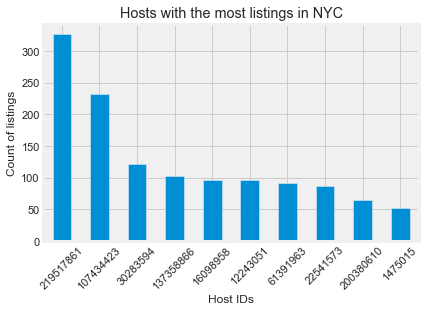

In [13]:
topten_viz = topten_hosts.plot(kind='bar')
topten_viz.set_title('Hosts with the most listings in NYC')
topten_viz.set_ylabel('Count of listings')
topten_viz.set_xlabel('Host IDs')
topten_viz.set_xticklabels(topten_viz.get_xticklabels(), rotation=45)

In [26]:
# Get a count by district
district_count = airbnb.groupby('district').agg('count').reset_index()
district_count.head()

,district,name,host_id,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,Bronx,1089,1090,1090,1090,1090,1090,1090,1090,1090,1090,1090,1090
1,Brooklyn,20089,20095,20095,20095,20095,20095,20095,20095,20095,20095,20095,20095
2,Manhattan,21651,21660,21660,21660,21660,21660,21660,21660,21660,21660,21660,21660
3,Queens,5666,5666,5666,5666,5666,5666,5666,5666,5666,5666,5666,5666
4,Staten Island,373,373,373,373,373,373,373,373,373,373,373,373


In [27]:
# Dropping useless columns
district_count.drop(['host_id', 'neighbourhood',
                     'latitude', 'longitude', 'room_type', 'price', 'minimum_nights',
                     'number_of_reviews', 'reviews_per_month',
                     'calculated_host_listings_count', 'availability_365'],
                    axis=1, inplace=True)

In [28]:
district_count.head()

,district,name
0,Bronx,1089
1,Brooklyn,20089
2,Manhattan,21651
3,Queens,5666
4,Staten Island,373


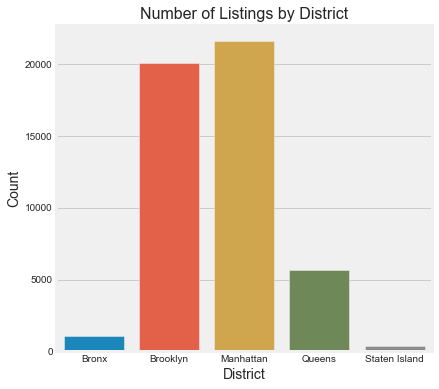

In [29]:
#Plot the count by district
fig, ax1 = plt.subplots(1,1, figsize=(6,6))
sns.barplot(x='district', y='name', data=district_count, ax=ax1)

ax1.set_title('Number of Listings by District', fontsize=16)
ax1.set_xlabel('District', fontsize=14)
ax1.set_ylabel('Count', fontsize=14)
ax1.tick_params(axis='both', labelsize=10)

In [30]:
# Here we are using geopandas to bring in a base layer of NYC districts
nyc = gpd.read_file(gpd.datasets.get_path('nybb'))
nyc.head()

,BoroCode,BoroName,Shape_Leng,Shape_Area,geometry
0,5,Staten Island,330470.010332,1.623820e+09,(POLYGON ((970217.0223999023 145643.3322143555...
1,4,Queens,896344.047763,3.045213e+09,(POLYGON ((1029606.076599121 156073.8142089844...
2,3,Brooklyn,741080.523166,1.937479e+09,(POLYGON ((1021176.479003906 151374.7969970703...
3,1,Manhattan,359299.096471,6.364715e+08,(POLYGON ((981219.0557861328 188655.3157958984...
4,2,Bronx,464392.991824,1.186925e+09,(POLYGON ((1012821.805786133 229228.2645874023...


In [31]:
# Renaming the column to district to join the data to it 
nyc.rename(columns={'BoroName':'district'}, inplace=True)

# Joing data
district_count__geo = nyc.merge(district_count, on='district')

# Renaming column id to accurately reflect count
district_count__geo.rename(columns={'id':'count'}, inplace=True)

In [32]:
district_count__geo.head()

,BoroCode,district,Shape_Leng,Shape_Area,geometry,name
0,5,Staten Island,330470.010332,1.623820e+09,(POLYGON ((970217.0223999023 145643.3322143555...,373
1,4,Queens,896344.047763,3.045213e+09,(POLYGON ((1029606.076599121 156073.8142089844...,5666
2,3,Brooklyn,741080.523166,1.937479e+09,(POLYGON ((1021176.479003906 151374.7969970703...,20089
3,1,Manhattan,359299.096471,6.364715e+08,(POLYGON ((981219.0557861328 188655.3157958984...,21651
4,2,Bronx,464392.991824,1.186925e+09,(POLYGON ((1012821.805786133 229228.2645874023...,1089


(905464.739038086, 1075092.8783935548, 112485.76063504723, 280480.4142594267)

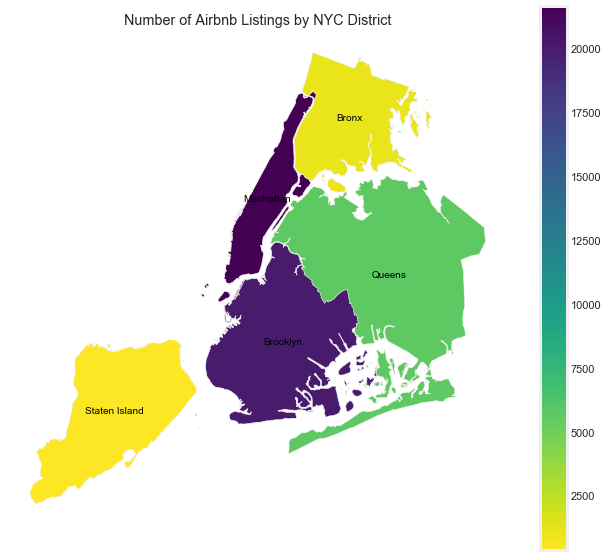

In [36]:
#Plot the count by district into a map
fig,ax = plt.subplots(1,1, figsize=(10,10))
district_count__geo.plot(column='name', cmap='viridis_r', alpha=1, ax=ax, legend=True)
district_count__geo.apply(lambda x: ax.annotate(s=x.district, color='black', xy=x.geometry.centroid.coords[0],ha='center'), axis=1)
plt.title("Number of Airbnb Listings by NYC District")
plt.axis('off')

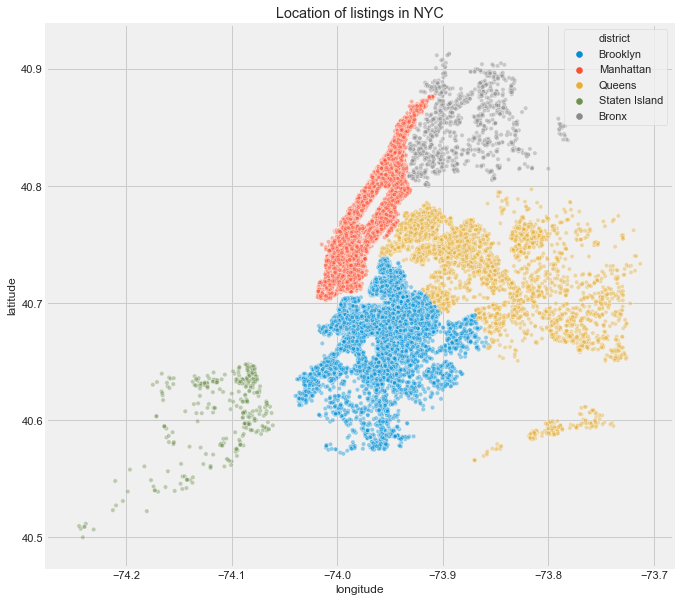

In [37]:
# Reviewing the listings by location
plt.figure(figsize=(10,10))
plt.title('Location of listings in NYC')
sns.scatterplot(x='longitude', y='latitude', hue='district', alpha=0.4, s=20, data=airbnb)

In [38]:
# Checking outliers amount using std distance
print(len(raw_data) - len(remove_outliers(raw_data, 'price', 2)))
print(len(raw_data) - len(remove_outliers(raw_data, 'price', 3)))

767
388


In [50]:
# Creating subsets using 3 std distance
airbnb_3std = remove_outliers(raw_data, 'price', 1)
airbnb_3std.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


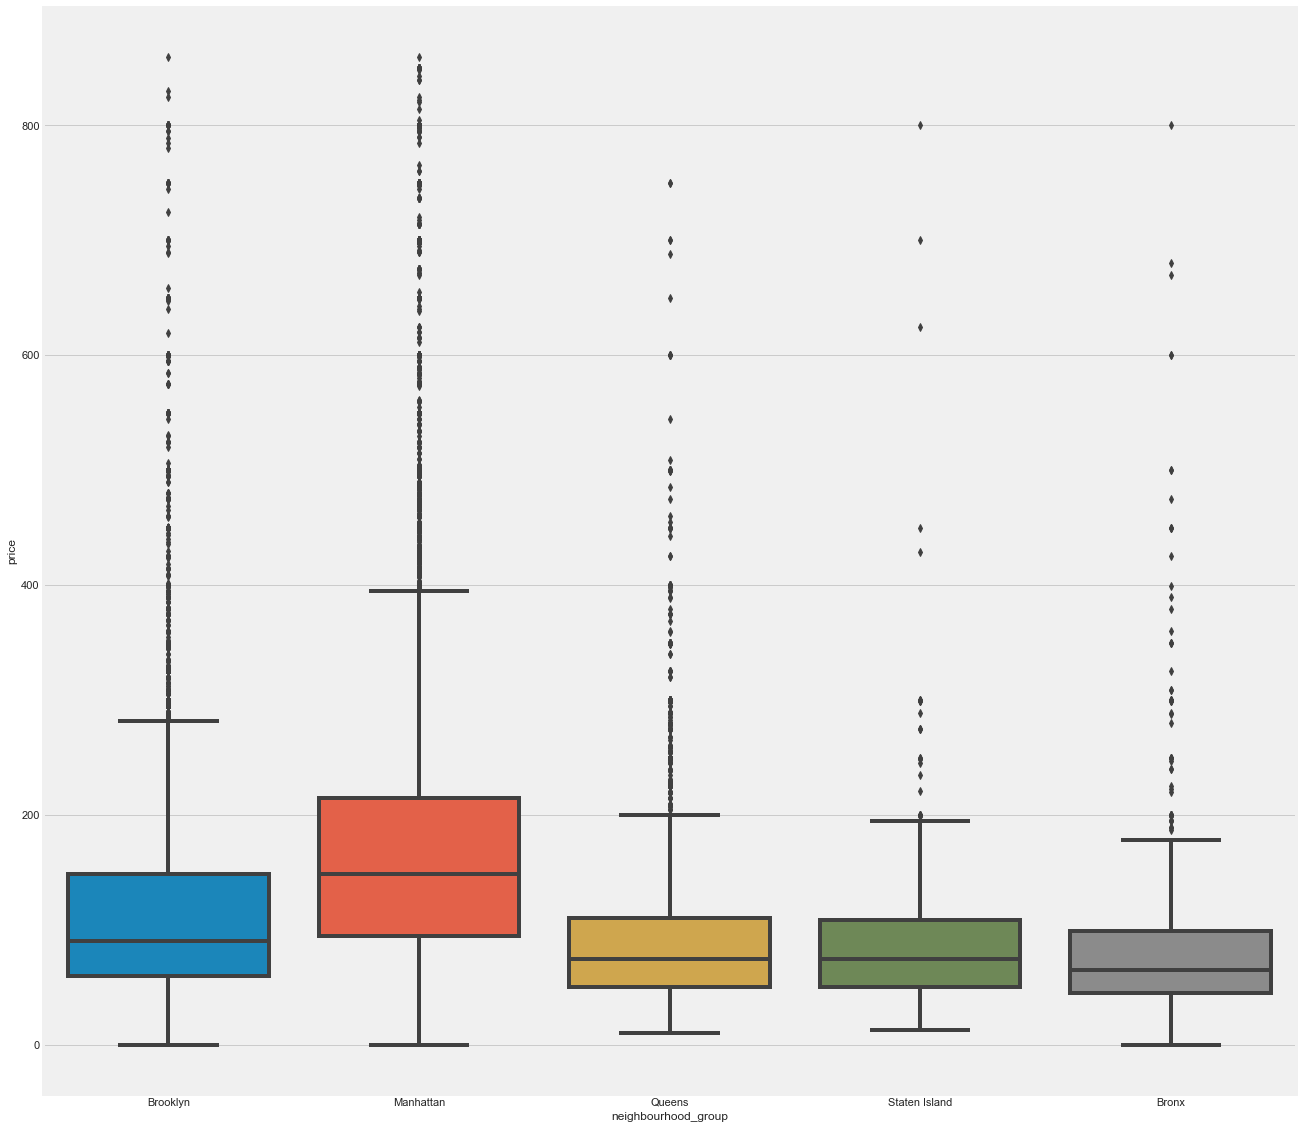

In [45]:
#Plot the price range of each district
fig, ax = plt.subplots(1,1, figsize=(20,20))
sns.boxplot(x='neighbourhood_group', y='price', data=airbnb_3std)

The data for price is highly skewed. The figure suggests that there's a possibility of distinction between the price ranges by listing features (maybe for room types?)

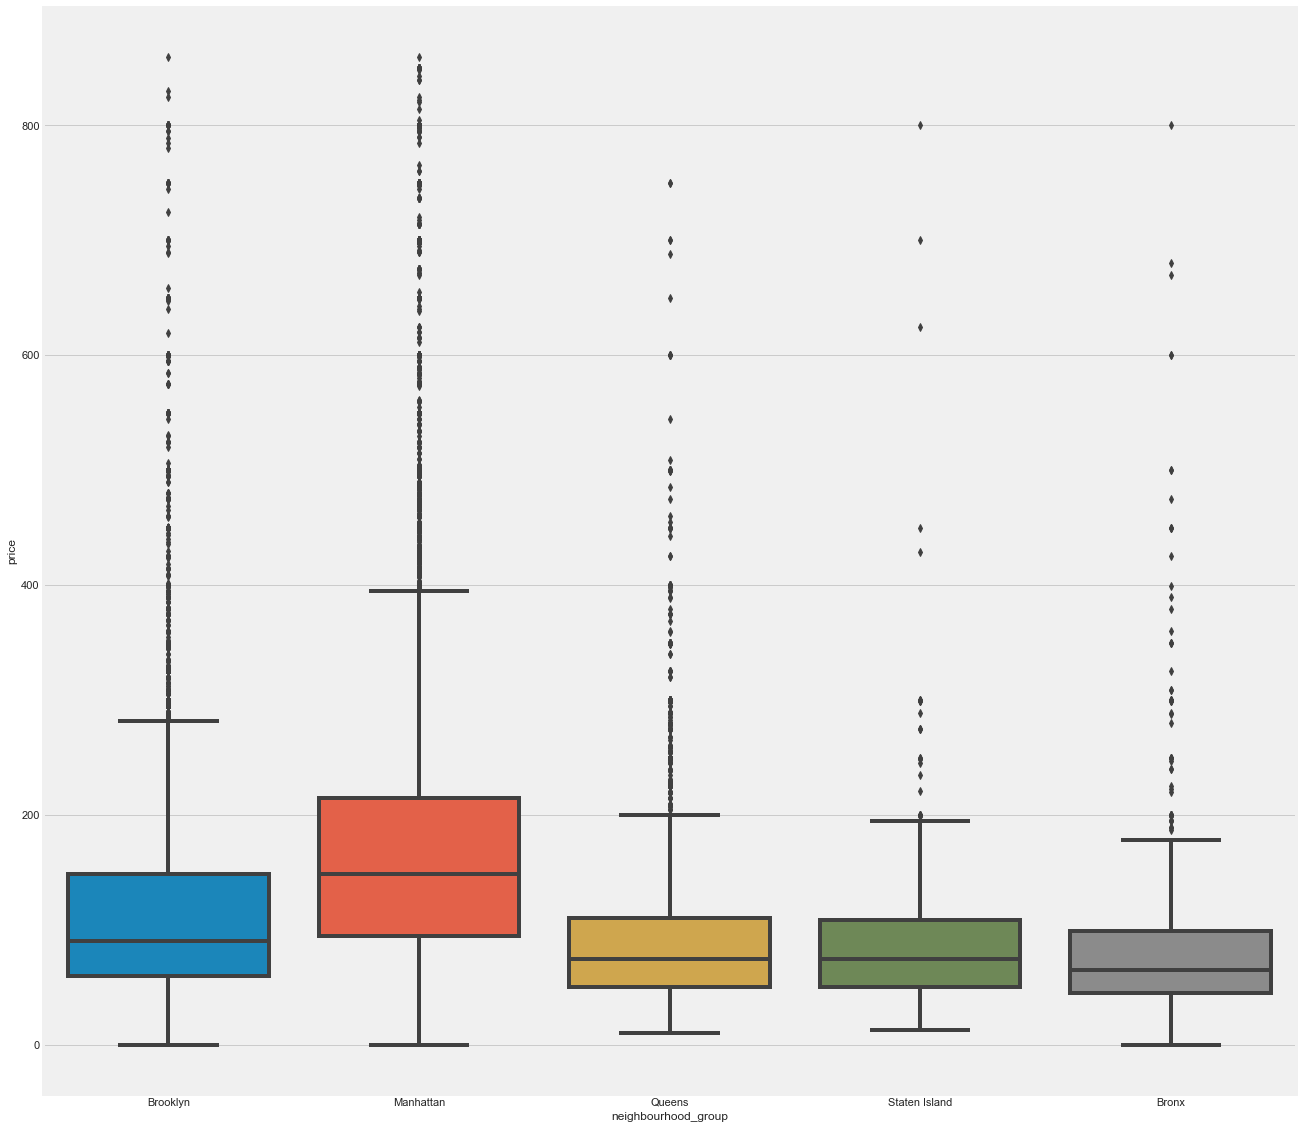

In [46]:
# Plot the price range of each district for private rooms
fig, ax = plt.subplots(1,1, figsize=(20,20))
sns.boxplot(x='neighbourhood_group', y='price', data=airbnb_3std)

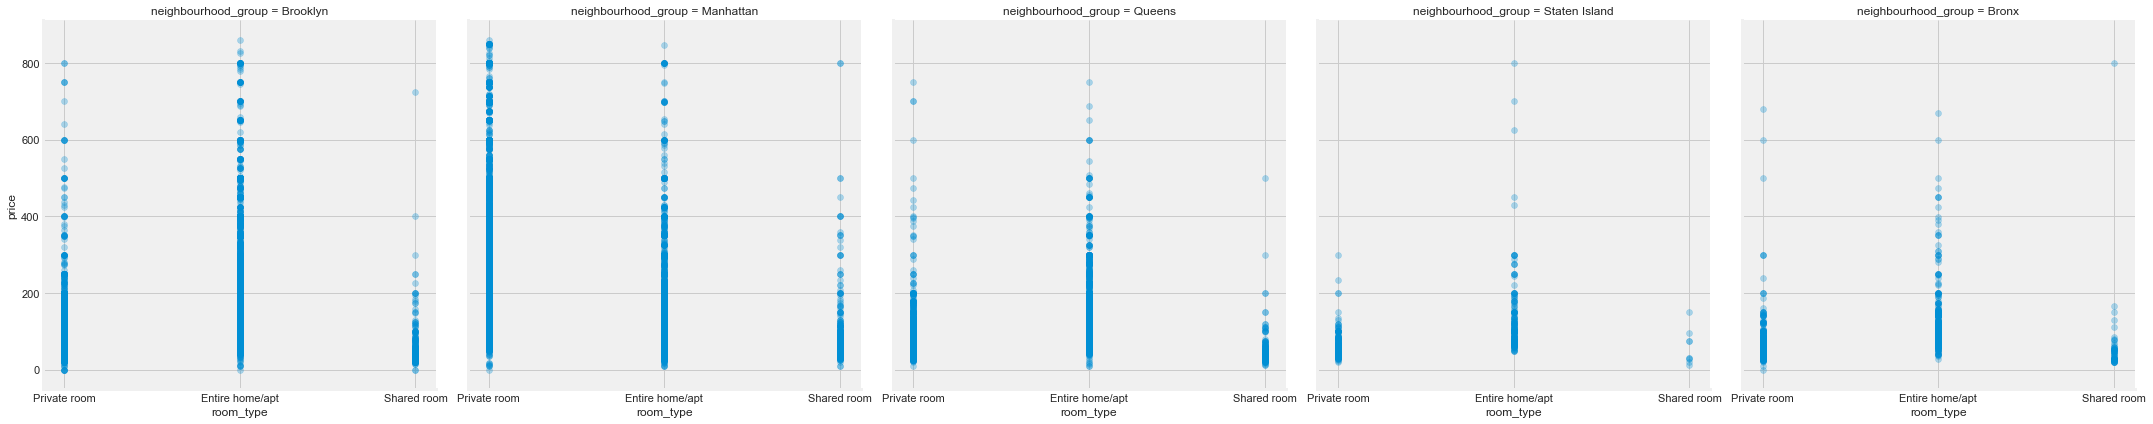

In [47]:
g = sns.FacetGrid(airbnb_3std, col="neighbourhood_group", col_wrap=5, height=6)
g.map(plt.scatter, "room_type", "price", alpha=.3)

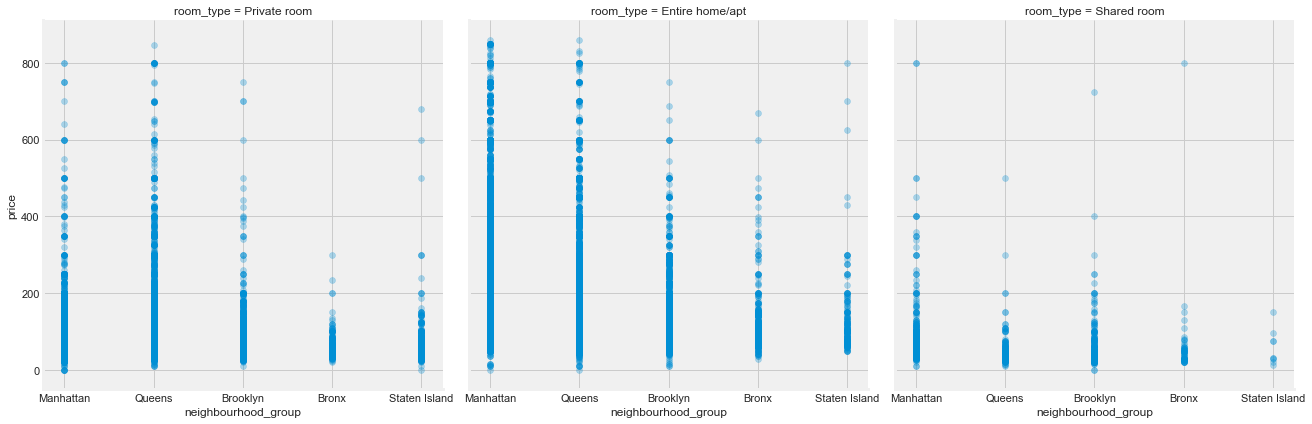

In [48]:
g = sns.FacetGrid(airbnb_3std, col="room_type", col_wrap=5, height=6)
g.map(plt.scatter, "neighbourhood_group", "price", alpha=.3)

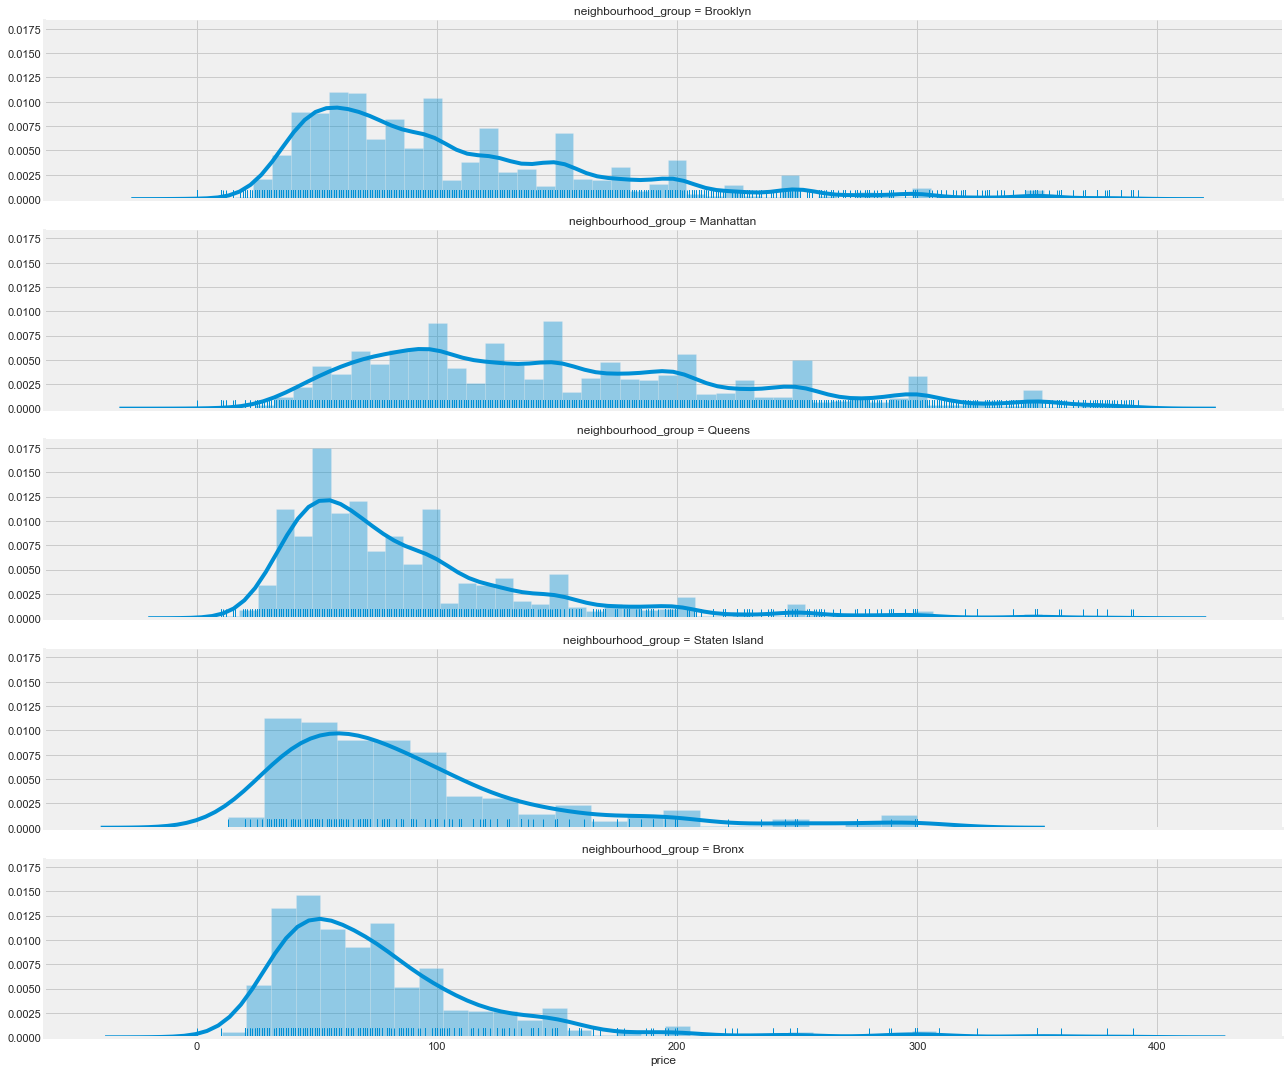

In [51]:
g = sns.FacetGrid(airbnb_3std, row="neighbourhood_group", height=3, aspect=6)
g.map(sns.distplot, "price", hist=True, rug=True);

#### Price Distribution of Airbnb in Brooklyn
The price distribution of Airbnb in Brooklyn averages around 50-500 dollars per night depending upon the neighbourhood.

#### Price Distribution of Airbnb in Manhattan
The price distribution of Airbnb in Manhattan averages around 100-800 dollars per night depending upon the neighbourhood.

#### Price Distribution of Airbnb in Queens
The price distribution of Airbnb in Queens averages around 100-500 dollars per night depending upon the neighbourhood.

#### Price Distribution of Airbnb in Staten Island
The price distribution of Airbnb in Staten Islands averages around 50-400 dollars per night depending upon the neighbourhood.

#### Price Distribution of Airbnb in Bronx
The price distribution of Airbnb in Bronx averages around 50-250 dollars per night depending upon the neighbourhood.